<a href="https://colab.research.google.com/github/DavidSokola/colab/blob/main/20250218_succes_YoloV11_Hailo_Compilation_ESP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Código proporcionado en la Comunidad Hailo.**

https://community.hailo.ai/t/guide-to-using-the-dfc-to-convert-a-modified-yolov11-on-google-colab/7131/14

Agradezco la ayuda a Trieut415

# 1. Convirtiendo nuestro archivo PyTorch en ONNX

En primer lugar, tenemos que convertir nuestro archivo PyTorch (.pt) en un archivo ONNX, para que esté en un formato listo para ser compilado en nuestro acelerador de hardware Raspberry Pi AI Hat+. Este dispositivo cuenta con un módulo 13/26 TOPS que se puede combinar con la Raspberry Pi 5.

In [ ]:
!pip install ultralytics
!pip install onnx
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.1/910.1 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.3 MB/s eta 0:00:00


Importando el modelo preentrenado **YOLO11s**

Convertir y exportar nuestro archivo PyTorch.

In [ ]:
import torch
from ultralytics import YOLO
import cv2
import numpy as np
from IPython.display import display, Image
import os

# Cargar el modelo preentrenado
model = YOLO('yolo11s.pt')

# Load our model into our environment
checkpoint = torch.load('/content/yolo11s.pt')
model = checkpoint['model']

model = model.float()
model.eval()

# Dummy input in FP32
dummy_input = torch.randn(16, 3, 640, 640, dtype=torch.float)

# Export to ONNX
torch.onnx.export(
    model,
    dummy_input,
    "/content/best.onnx",
    export_params=True,
    opset_version=11,  # Adjust opset version if needed
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output']
)
print("ONNX model exported successfully!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 18.4M/18.4M [00:00<00:00, 146MB/s]
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/head.py:105: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.format != "imx" and (self.dynamic or self.shape != shape):
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/tal.py:338: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  for i, stride in enumerate(strides):


ONNX model exported successfully!


Probando la validez de nuestro modelo para garantizar que nuestra conversión funcionó correctamente

In [ ]:
import onnx
import onnxruntime as ort
import torch

# Load the ONNX model
onnx_model = onnx.load("/content/best.onnx")
onnx.checker.check_model(onnx_model)
print("ONNX model is valid!")

# Test the ONNX model with ONNX Runtime
dummy_input = torch.randn(16, 3, 640, 640).numpy()
ort_session = ort.InferenceSession("/content/best.onnx")
outputs = ort_session.run(None, {"input": dummy_input})
print(outputs[0])

ONNX model is valid!
[[[     12.095      12.486      23.357 ...      521.49      565.71      596.38]
  [      4.091      3.6364      4.2469 ...      604.15      600.88      599.14]
  [     23.631      23.393      44.825 ...      291.76      263.39      197.45]
  ...
  [ 9.8348e-07  3.8743e-07  4.1723e-07 ...  2.7716e-06  2.8014e-06  2.9504e-06]
  [ 3.5763e-07  3.5763e-07  3.2783e-07 ...  2.2054e-06  2.1458e-06   2.116e-06]
  [ 5.0664e-07  3.8743e-07  3.8743e-07 ...  2.1458e-06  1.9073e-06   1.967e-06]]

 [[     20.045      21.065      25.373 ...      515.73      562.16      591.04]
  [     5.3167      4.5354      4.7803 ...      602.77       598.5      596.43]
  [     40.215      42.004      49.516 ...      301.65      280.25      206.51]
  ...
  [ 5.3644e-07  2.9802e-07  2.9802e-07 ...  2.8014e-06   2.861e-06    3.01e-06]
  [ 2.9802e-07  2.3842e-07  2.3842e-07 ...  2.2054e-06   2.116e-06  2.1756e-06]
  [ 2.9802e-07  2.6822e-07  1.7881e-07 ...  2.0862e-06  1.8179e-06  1.9073e-06]]

 [[

# 2. Descargando el Compilador de Flujo de Datos de Hailo
Esta herramienta sirve para convertir nuestro modelo ONNX en su formato final para ser utilizado en el Hailo 8.

Hay tres formas de hacer esto:
1. Usar el Compilador de Flujo de Datos (DFC)
2. Usar la [Integración de Python del Model Zoo](https://github.com/hailo-ai/hailo_model_zoo)
3. Usar el [AI SW Docker Suite](https://hailo.ai/developer-zone/software-downloads/)

El DFC nos permite convertir modelos que no están ya precompilados en el model-zoo, y nos permite reentrenar/converter modelos personalizados que tienen arquitecturas similares a las que ya están en el model zoo.

Para usar esto, tendremos que convertir nuestro archivo ONNX generado en el formato HEF (Hailo Executable File) utilizado por el Hailo 8.

Los pasos son los siguientes:

1. [Analizar](https://hailo.ai/developer-zone/documentation/v3-29-0/?sp_referrer=tutorials_notebooks%2Fnotebooks%2FDFC_1_Parsing_Tutorial.html) el modelo
2. [Optimización](https://hailo.ai/developer-zone/documentation/v3-29-0/?sp_referrer=tutorials_notebooks%2Fnotebooks%2FDFC_2_Model_Optimization_Tutorial.html&highlight=layers)
3. [Compilación](https://hailo.ai/developer-zone/documentation/v3-29-0/?page=tutorials_notebooks%2Fnotebooks%2FDFC_3_Compilation_Tutorial.html)
4. [Ejecutar inferencia](https://hailo.ai/developer-zone/documentation/v3-29-0/file/?page=tutorials_notebooks%2Fnotebooks%2FDFC_4_Inference_Tutorial.html)

Multi-Modelo
https://hailo.ai/developer-zone/documentation/hailort-v4-19-0/?sp_referrer=api/python_api.html


Se instalan todos los paquetes de sitio necesarios.

In [ ]:
!sudo apt-get update
!sudo apt-get install -y python3-dev python3-distutils python3-tk libfuse2 graphviz libgraphviz-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [62.5 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,606 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,642 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,228 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,859 kB

Instalar el paquete virtualenv

In [ ]:
!pip install --upgrade pip virtualenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 27.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


Creando un venv.

In [ ]:
!pip install virtualenv


In [ ]:
!virtualenv my_env --python=python3.10


created virtual environment CPython3.10.12.final.0-64 in 1036ms
  creator CPython3Posix(dest=/content/my_env, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==24.3.1, setuptools==75.8.0, wheel==0.45.1
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


Al instalar el DFC en nuestro venv, debemos tener en cuenta que tenemos que instalarlo usando nuestra versión de Python dentro del entorno virtual.

In [ ]:
!my_env/bin/pip install numpy==1.23.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 91.7 MB/s eta 0:00:00


In [ ]:
# Instalar gdown si no está instalado
!pip install gdown

# IDs de los archivos
# hailo_dataflow_id = "1Jb1Wya0MN04xZTPaWEbZDlV3IIdQR-5g" version 3.29
hailo_dataflow_id = "1CZ_ApOClYLGw57F7ps-rsDMnq1IcD0s2"

#hailo_model_zoo_id = "1r225Q2PwERaCSWjGWEfRNVWXPmdufwgv"

# Descargar los archivos .whl

!gdown --id {hailo_dataflow_id} -O hailo_dataflow_compiler-3.30.0-py3-none-linux_x86_64.whl
#!gdown --id {hailo_model_zoo_id} -O hailo_model_zoo-2.13.0-py3-none-any.whl


# Instalar los paquetes
!my_env/bin/pip install /content/hailo_dataflow_compiler-3.30.0-py3-none-linux_x86_64.whl
#!my_env/bin/pip install /content/hailo_model_zoo-2.13.0-py3-none-any.whl

# Verificar la instalación
!pip list | grep hailo



/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1CZ_ApOClYLGw57F7ps-rsDMnq1IcD0s2
From (redirected): https://drive.google.com/uc?id=1CZ_ApOClYLGw57F7ps-rsDMnq1IcD0s2&confirm=t&uuid=f60c1002-0fd0-4b8c-b0e5-4b289013b768
To: /content/hailo_dataflow_compiler-3.30.0-py3-none-linux_x86_64.whl
100% 512M/512M [00:04<00:00, 111MB/s]
Processing ./hailo_dataflow_compiler-3.30.0-py3-none-linux_x86_64.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached py_c

Asegúrate de que está correctamente instalado.

In [ ]:
!my_env/bin/hailo --version

[info] Current Time: 03:35:31, 01/17/25
[info] CPU: Architecture: x86_64, Model: Intel(R) Xeon(R) CPU @ 2.00GHz, Number Of Cores: 96, Utilization: 0.4%
[info] Memory: Total: 334GB, Available: 327GB
[info] System info: OS: Linux, Kernel: 6.1.85+
[info] Hailo DFC Version: 3.30.0
[info] HailoRT Version: Not Installed
[info] PCIe: No Hailo PCIe device was found
[info] Running `hailo --version`
Hailo Dataflow Compiler v3.30.0


### 2a. Analizando nuestro archivo ONNX

#### Identificación de nombres adecuados de nodo final.

El primer paso del proceso de análisis es decirle a la herramienta de qué capas/nodos esperar la salida, también conocidos como (nodos finales). Una vez que identificamos cuáles son los nodos finales correctos utilizando Netron, podemos continuar con el primer paso de nuestra compilación, el análisis. En nuestro caso, desde YoloV8 hasta YoloV11, todos utilizan la misma arquitectura, donde para cada salida de mapa de características, hay dos nodos finales por mapa. En nuestra versión modificada de Yolo, eliminamos uno de los mapas de características, por lo que ahora nos quedan dos, lo que significa que tenemos un total de cuatro nodos finales, en lugar de seis. Para identificar los nodos finales de Yolo, son los nodos justo antes de las operaciones de post-procesamiento en la parte inferior del modelo, que se muestran a continuación:
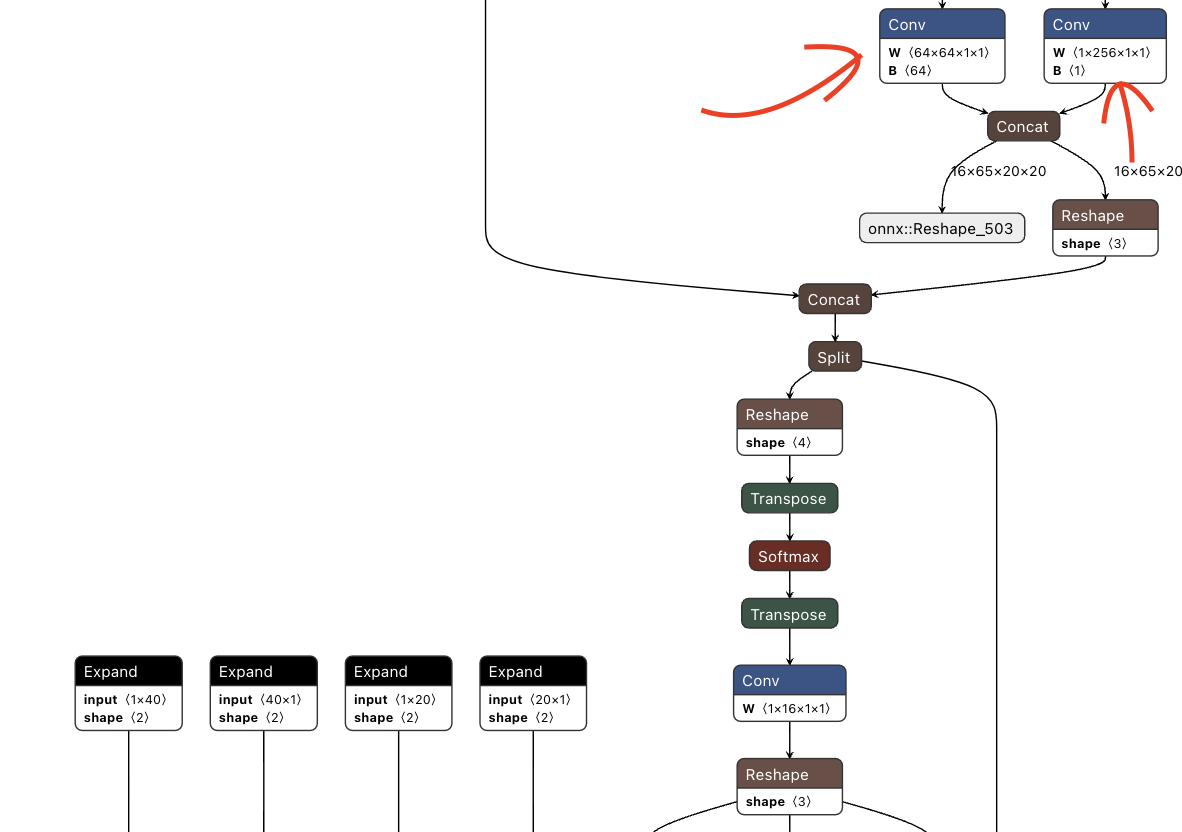


And here is the other branch leading to the concat operation at the end.

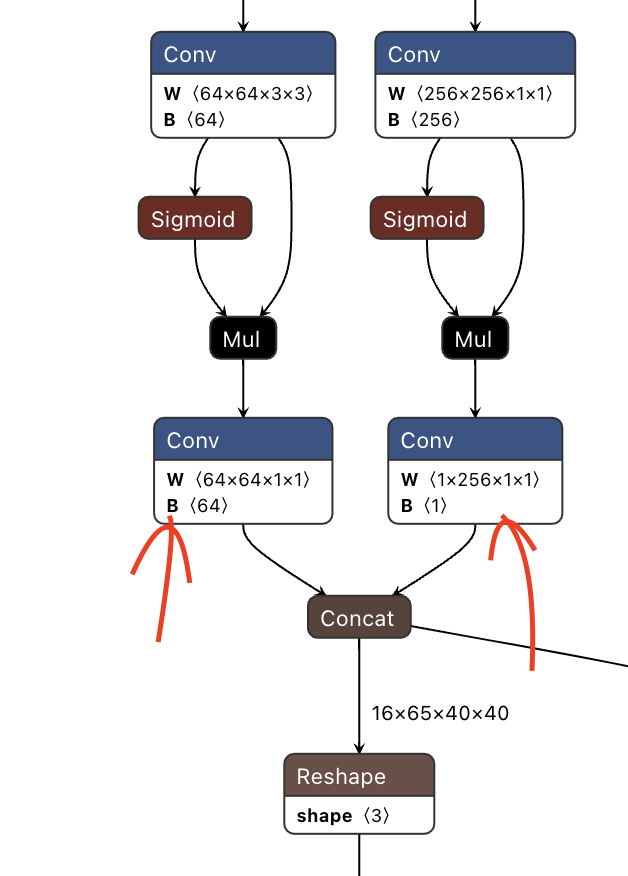

Ahora, una vez que hemos identificado nuestros nodos finales (puede hacer clic en ellos en netron para encontrar los nombres, use el nombre del nodo), escribiremos nuestro script y lo guardaremos localmente.


In [ ]:
code_content = '''
from hailo_sdk_client import ClientRunner
import onnx
import os
from typing import List, Dict, Optional

class ModelConverter:
    def __init__(self,
                 onnx_path: str,
                 model_name: str = "yolov11_model",
                 hw_arch: str = "hailo8",
                 batch_size: int = 16):
        self.onnx_path = onnx_path
        self.model_name = model_name
        self.hw_arch = hw_arch
        self.batch_size = batch_size
        self.end_node_names = [
            "/model.23/cv2.0/cv2.0.2/Conv",
            "/model.23/cv3.0/cv3.0.2/Conv",
            "/model.23/cv2.1/cv2.1.2/Conv",
            "/model.23/cv3.1/cv3.1.2/Conv",
            "/model.23/cv2.2/cv2.2.2/Conv",
            "/model.23/cv3.2/cv3.2.2/Conv"
        ]

    def check_opset_version(self, model) -> bool:
        for opset in model.opset_import:
            if opset.domain == "" and opset.version > 17:
                print(f"⚠️ Advertencia: El modelo usa Opset {opset.version}")
                return False
        return True

    def convert_ir_version(self, model) -> str:
        """Convierte la versión IR del modelo si es necesario."""
        if model.ir_version > 8:
            print(f"📝 Convirtiendo modelo de versión IR {model.ir_version} a versión 8")
            model.ir_version = 8
            converted_path = self.onnx_path.replace('.onnx', '_converted.onnx')
            onnx.save(model, converted_path)
            return converted_path
        return self.onnx_path

    def verify_end_nodes(self, model) -> None:
        """Verifica la existencia de nodos finales."""
        available_nodes = {node.name for node in model.graph.node}
        missing = [node for node in self.end_node_names if node not in available_nodes]
        if missing:
            raise ValueError(f"❌ Nodos finales faltantes:\\n" + "\\n".join(missing))

    def convert(self) -> str:
        """Realiza la conversión completa del modelo."""
        if not os.path.exists(self.onnx_path):
            raise FileNotFoundError(f"❌ No se encontró el archivo ONNX: {self.onnx_path}")

        try:
            # Carga y validación inicial
            print("🔄 Cargando modelo ONNX...")
            model = onnx.load(self.onnx_path)

            # Verificaciones
            self.check_opset_version(model)
            self.verify_end_nodes(model)

            # Conversión IR si es necesario
            self.onnx_path = self.convert_ir_version(model)

            # Configuración de entrada
            input_node = model.graph.input[0]
            input_node_name = input_node.name
            input_shapes = [dim.dim_value for dim in input_node.type.tensor_type.shape.dim]
            print(f"📊 Dimensiones de entrada: {input_shapes}")

            # Configuración del runner
            runner = ClientRunner(hw_arch=self.hw_arch)
            net_input_shapes = {
                input_node_name: [self.batch_size, 3, 640, 640]
            }

            # Traducción del modelo
            print("🚀 Iniciando traducción del modelo...")
            hn, npz = runner.translate_onnx_model(
                self.onnx_path,
                self.model_name,
                end_node_names=self.end_node_names,
                net_input_shapes=net_input_shapes
            )

            # Guardado del modelo
            har_path = f"{self.model_name}_hailo_model.har"
            runner.save_har(har_path)
            print(f"✅ Modelo HAR guardado como: {har_path}")
            return har_path

        except Exception as e:
            print(f"❌ Error durante la conversión: {str(e)}")
            raise

if __name__ == "__main__":
    try:
        converter = ModelConverter("/content/best.onnx")
        har_file = converter.convert()
        print(f"✨ Proceso completado exitosamente. Archivo HAR: {har_file}")
    except Exception as e:
        print(f"❌ Error en el proceso principal: {str(e)}")
'''

with open("translate_model.py", "w") as f:
    f.write(code_content)



Ejecutando nuestro script con el venv python.

In [ ]:
!my_env/bin/python translate_model.py

🔄 Cargando modelo ONNX...
📊 Dimensiones de entrada: [16, 3, 640, 640]
🚀 Iniciando traducción del modelo...
[info] Translation started on ONNX model yolov11_model
[info] Restored ONNX model yolov11_model (completion time: 00:00:00.24)
[info] Extracted ONNXRuntime meta-data for Hailo model (completion time: 00:00:02.49)
[info] NMS structure of yolov8 (or equivalent architecture) was detected.
[info] In order to use HailoRT post-processing capabilities, these end node names should be used: /model.23/cv2.0/cv2.0.2/Conv /model.23/cv3.0/cv3.0.2/Conv /model.23/cv3.1/cv3.1.2/Conv /model.23/cv2.1/cv2.1.2/Conv /model.23/cv3.2/cv3.2.2/Conv /model.23/cv2.2/cv2.2.2/Conv.
[info] Start nodes mapped from original model: 'input': 'yolov11_model/input_layer1'.
[info] End nodes mapped from original model: '/model.23/cv2.0/cv2.0.2/Conv', '/model.23/cv3.0/cv3.0.2/Conv', '/model.23/cv2.1/cv2.1.2/Conv', '/model.23/cv3.1/cv3.1.2/Conv', '/model.23/cv2.2/cv2.2.2/Conv', '/model.23/cv3.2/cv3.2.2/Conv'.
[info] Tra

### 4b. Optimizing our HAR file

Descargando nuestro archivo.

Dado que Hailo tiene su propio proceso de cambio de nombre, tenemos que encontrar los nuevos nombres de nuestros nodos finales. A continuación, se incluye un diccionario de capas y operaciones; busque los nombres de los nodos finales identificados por output_layers_order.

In [ ]:
with open("inspect_dict.py", "w") as f:
    f.write("""
from hailo_sdk_client import ClientRunner

# Load the HAR file
har_path = "/content/yolov11_model_hailo_model.har"

runner = ClientRunner(har=har_path)

from pprint import pprint

try:
    # Access the HailoNet as an OrderedDict
    hn_dict = runner.get_hn()  # Or use runner._hn if get_hn() is unavailable
    print("Inspecting layers from HailoNet (OrderedDict):")

    # Pretty-print each layer
    for key, value in hn_dict.items():
        print(f"Key: {key}")
        pprint(value)
        print("\\n" + "="*80 + "\\n")  # Add a separator between layers for clarity

except Exception as e:
    print(f"Error while inspecting hn_dict: {e}")
""")

In [ ]:
!my_env/bin/python inspect_dict.py

Inspecting layers from HailoNet (OrderedDict):
Key: name
'yolov11_model'


Key: net_params
OrderedDict([('version', '1.0'),
             ('stage', 'HN'),
             ('clusters_placement', [[]]),
             ('clusters_to_skip', []),
             ('output_layers_order',
              ['yolov11_model/conv51',
               'yolov11_model/conv54',
               'yolov11_model/conv62',
               'yolov11_model/conv65',
               'yolov11_model/conv77',
               'yolov11_model/conv80']),
             ('is_transformer', True),
             ('transposed_net', False),
             ('net_scopes', ['yolov11_model']),
             ('lora_adapters', [])])


Key: layers
OrderedDict([('yolov11_model/input_layer1',
              OrderedDict([('type', 'input_layer'),
                           ('input', []),
                           ('output', ['yolov11_model/conv1']),
                           ('input_shapes', [[-1, 640, 640, 3]]),
                           ('output_shapes', 

A continuación, generamos datos de calibración para optimizar nuestro modelo, lo que ayuda al DFC a optimizar el modelo de red y los parámetros utilizando un conjunto de calibración preprocesado. Este proceso solo debe realizarse una vez.


In [ ]:
# Importando dataset COCO
# Este archivo contiene imágenes en formato jpg para entrenamiento
# --------------------------------------------------------------

# Importando bibliotecas necesarias
import os                 # Para operaciones del sistema de archivos
import shutil            # Para operaciones avanzadas de archivos
from pathlib import Path # Para manejo de rutas de manera moderna

# Configuración de descarga desde Google Drive
file_id = "1RJzzDzpL1p1kneOUTDrIczPokJUj48xe"    # ID único del archivo en Google Drive
destination = "/content/dataset.tar.gz"                   # Ruta donde se guardará el archivo RAR

# Instalación y ejecución de gdown para descargar desde Google Drive
!pip install gdown                                 # Instala la herramienta gdown si no está presente
!gdown --id {file_id}                             # Descarga el archivo usando el ID de Google Drive

# Configuración del directorio de extracción
output_dir = "/content"                           # Directorio donde se extraerán las imágenes
Path(output_dir).mkdir(parents=True, exist_ok=True)    # Crea el directorio si no existe

# Extracción del archivo RAR
!tar -xzf /content/dataset.tar.gz -C /content/img                    # 'x' extrae con rutas completas


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1RJzzDzpL1p1kneOUTDrIczPokJUj48xe
From (redirected): https://drive.google.com/uc?id=1RJzzDzpL1p1kneOUTDrIczPokJUj48xe&confirm=t&uuid=b70d36e1-3246-43b3-9cde-fc4277bc030d
To: /content/dataset.tar.gz
100% 29.2M/29.2M [00:00<00:00, 57.9MB/s]
tar: /content/img: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
# Extracción del archivo RAR
!tar -xzf /content/dataset.tar.gz -C /content                  # 'x' extrae con rutas completas


In [ ]:
import numpy as np
from PIL import Image
import os
from google.colab import drive

# Paths to directories and files
image_dir = '/content/img'
output_dir = '/content'
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# File paths for saving calibration data
calibration_data_path = os.path.join(output_dir, "calibration_data.npy")
processed_data_path = os.path.join(output_dir, "processed_calibration_data.npy")

# Initialize an empty list for calibration data
calib_data = []

# Process all image files in the directory
for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        try:
            img = Image.open(img_path).resize((640, 640))  # Resize to desired dimensions
            img_array = np.array(img) / 255.0  # Normalize to [0, 1]
            # Check if the image has 3 color channels before appending
            if img_array.shape == (640, 640, 3):
                calib_data.append(img_array)
            else:
                print(f"Skipping image with incorrect shape: {img_path}, shape: {img_array.shape}")
        except AttributeError:
            print(f"Skipping corrupted image: {img_path}")  # Print a message for skipped images
            continue # Move to the next image

# Convert the calibration data to a NumPy array
calib_data = np.array(calib_data)

# Save the normalized calibration data
np.save(calibration_data_path, calib_data)
print(f"Normalized calibration dataset saved with shape: {calib_data.shape} to {calibration_data_path}")

# Scale the normalized data back to [0, 255]
processed_calibration_data = calib_data * 255.0

# Save the processed calibration data
np.save(processed_data_path, processed_calibration_data)
print(f"Processed calibration dataset saved with shape: {processed_calibration_data.shape} to {processed_data_path}")


Normalized calibration dataset saved with shape: (471, 640, 640, 3) to /content/calibration_data.npy
Processed calibration dataset saved with shape: (471, 640, 640, 3) to /content/processed_calibration_data.npy


# CODIGO MEJORADO

In [ ]:
import numpy as np
from PIL import Image
import os
from google.colab import drive
import gc
from tqdm import tqdm

class CalibrationDataProcessor:
    def __init__(self,
                 image_dir: str = '/content/img',
                 output_dir: str = '/content',
                 batch_size: int = 16,
                 target_size: tuple = (640, 640)):

        self.image_dir = image_dir
        self.output_dir = output_dir
        self.batch_size = batch_size
        self.target_size = target_size

        # Crear directorio de salida
        os.makedirs(output_dir, exist_ok=True)

        # Paths para los archivos
        self.calibration_data_path = os.path.join(output_dir, "calibration_data.npy")
        self.processed_data_path = os.path.join(output_dir, "processed_calibration_data.npy")

    def get_valid_image_files(self):
        """Obtiene la lista de archivos de imagen válidos."""
        return [f for f in os.listdir(self.image_dir)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    def process_image(self, img_path: str) -> np.ndarray:
        """Procesa una imagen individual."""
        try:
            img = Image.open(img_path).resize(self.target_size)
            img_array = np.array(img) / 255.0

            if img_array.shape == (*self.target_size, 3):
                return img_array
            else:
                print(f"Imagen con dimensiones incorrectas: {img_path}, shape: {img_array.shape}")
                return None

        except Exception as e:
            print(f"Error procesando imagen {img_path}: {str(e)}")
            return None

    def process_batch(self, image_files: list, start_idx: int) -> np.ndarray:
        """Procesa un lote de imágenes."""
        batch_data = []

        for img_name in image_files:
            img_path = os.path.join(self.image_dir, img_name)
            img_array = self.process_image(img_path)

            if img_array is not None:
                batch_data.append(img_array)

        return np.array(batch_data) if batch_data else None

    def save_batch(self, batch_data: np.ndarray, file_path: str, mode: str = 'wb'):
        """Guarda un lote de datos."""
        if mode == 'wb':
            np.save(file_path, batch_data)
        else:
            with open(file_path, 'ab') as f:
                np.save(f, batch_data)

    def process_dataset(self):
        """Procesa todo el conjunto de datos por lotes."""
        image_files = self.get_valid_image_files()
        total_images = len(image_files)

        if total_images == 0:
            print("No se encontraron imágenes válidas.")
            return

        # Inicializar archivos
        if os.path.exists(self.calibration_data_path):
            os.remove(self.calibration_data_path)
        if os.path.exists(self.processed_data_path):
            os.remove(self.processed_data_path)

        total_processed = 0

        # Procesar por lotes
        for batch_start in tqdm(range(0, total_images, self.batch_size),
                              desc="Procesando imágenes"):

            batch_end = min(batch_start + self.batch_size, total_images)
            batch_files = image_files[batch_start:batch_end]

            # Procesar lote
            batch_data = self.process_batch(batch_files, batch_start)

            if batch_data is not None:
                # Guardar datos normalizados
                self.save_batch(batch_data,
                              self.calibration_data_path,
                              'ab' if batch_start > 0 else 'wb')

                # Guardar datos procesados (escalados a 255)
                self.save_batch(batch_data * 255.0,
                              self.processed_data_path,
                              'ab' if batch_start > 0 else 'wb')

                total_processed += len(batch_data)

            # Limpiar memoria
            del batch_data
            gc.collect()

        print(f"\nProceso completado. Total de imágenes procesadas: {total_processed}")

if __name__ == "__main__":
    try:
        # Configurar el procesador
        processor = CalibrationDataProcessor(
            image_dir='/content/img',
            output_dir='/content',
            batch_size=16  # Ajusta según la memoria disponible
        )

        # Ejecutar el procesamiento
        processor.process_dataset()

    except Exception as e:
        print(f"Error durante el procesamiento: {str(e)}")


Procesando imágenes: 100%|██████████| 30/30 [00:46<00:00,  1.54s/it]


Proceso completado. Total de imágenes procesadas: 471


Creación de un nivel de gestión de servicios para ajustarse correctamente a nuestra arquitectura de modelo modificada.

In [ ]:
import json
import os
from google.colab import drive


drive.mount('/content/drive/', force_remount=True)

# Updated NMS layer configuration dictionary
nms_layer_config = {
    "nms_scores_th": 0.2,
    "nms_iou_th": 0.7,
    "image_dims": [
        640,
        640
    ],
    "max_proposals_per_class": 100,
    "classes": 80,
    "regression_length": 16,
    "background_removal": False,
    "background_removal_index": 0,
    "bbox_decoders": [
        {
            "name": "bbox_decoder1",
            "stride": 8,
            "reg_layer": "conv51",
            "cls_layer": "conv54"
        },
        {
            "name": "bbox_decoder2",
            "stride": 16,
            "reg_layer": "conv62",
            "cls_layer": "conv65"
        },
        {
            "name": "bbox_decoder3",
            "stride": 32,
            "reg_layer": "conv77",
            "cls_layer": "conv80"
        }
    ]
}


# Path to save the updated JSON configuration
output_dir = "/content"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
output_path = os.path.join(output_dir, "nms_layer_config.json")

# Save the updated configuration as a JSON file
with open(output_path, "w") as json_file:
    json.dump(nms_layer_config, json_file, indent=4)

print(f"NMS layer configuration saved to {output_path}")

Mounted at /content/drive/
NMS layer configuration saved to /content/nms_layer_config.json


Ahora estamos escribiendo un script para optimizar nuestro modelo, por lo que puedes encontrar archivos .alls de muestra en el modelo de Hailo.

In [ ]:
with open("optimize_model.py", "w") as f:
    f.write("""\
import os
from hailo_sdk_client import ClientRunner

model_name = "yolov11_model"
hailo_model_har_name = f"{model_name}_hailo_model.har"

assert os.path.isfile(hailo_model_har_name), "Please provide a valid path for the HAR file"

runner = ClientRunner(har=hailo_model_har_name)

# Sugerencia del último post Trieut415... https://community.hailo.ai/t/guide-to-using-the-dfc-to-convert-a-modified-yolov11-on-google-colab/7131/14?u=ahmedcr_net

alls = \"\"\"
normalization1 = normalization([0.0, 0.0, 0.0], [255.0, 255.0, 255.0])
change_output_activation(conv54, sigmoid)
change_output_activation(conv65, sigmoid)
change_output_activation(conv80, sigmoid)
nms_postprocess("/content/nms_layer_config.json", meta_arch=yolov8, engine=cpu)
performance_param(compiler_optimization_level=2)
\"\"\"

runner.load_model_script(alls)

calib_dataset = "/content/processed_calibration_data.npy"
assert os.path.isfile(calib_dataset), "Please provide a valid path for the calibration dataset"

runner.optimize(calib_dataset)

quantized_model_har_path = f"{model_name}_quantized_model.har"
runner.save_har(quantized_model_har_path)
print(f"Quantized HAR file saved to: {quantized_model_har_path}")
""")


Se está ejecutando con venv python.

In [ ]:
!my_env/bin/pip uninstall -y numpy scipy
!my_env/bin/pip install numpy==1.23.3 scipy==1.10.1


Found existing installation: numpy 1.23.3
Uninstalling numpy-1.23.3:
  Successfully uninstalled numpy-1.23.3
Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
  Using cached numpy-1.23.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 101.7 MB/s eta 0:00:00


In [ ]:
!my_env/bin/python optimize_model.py

[info] Loading model script commands to yolov11_model from string
[info] Starting Model Optimization
[warning] Reducing optimization level to 0 (the accuracy won't be optimized and compression won't be used) because there's less data than the recommended amount (1024), and there's no available GPU
[warning] Running model optimization with zero level of optimization is not recommended for production use and might lead to suboptimal accuracy results
[info] Model received quantization params from the hn
[info] MatmulDecompose skipped
[info] Starting Mixed Precision
[info] Model Optimization Algorithm Mixed Precision is done (completion time is 00:00:01.01)
[info] LayerNorm Decomposition skipped
[info] Starting Statistics Collector
[info] Using dataset with 16 entries for calibration
Calibration: 100% 16/16 [01:19<00:00,  4.96s/entries]
[info] Model Optimization Algorithm Statistics Collector is done (completion time is 00:01:22.99)
[info] Starting Fix zp_comp Encoding
[info] Model Optimiz

### 4c. Compilación final de Running en un archivo HEF.

Escribir un script local para realizar la conversión.

In [ ]:
with open("compile_model.py", "w") as f:
    f.write("""
from hailo_sdk_client import ClientRunner
import os

# Define the quantized model HAR file
model_name = "yolov11_model"
quantized_model_har_path = f"{model_name}_quantized_model.har"
output_directory = "/content/drive/MyDrive/HAILO8"
os.makedirs(output_directory, exist_ok=True)

# Initialize the ClientRunner with the HAR file
runner = ClientRunner(har=quantized_model_har_path)
print("[info] ClientRunner initialized successfully.")

# Compile the model
try:
    hef = runner.compile()
    print("[info] Compilation completed successfully.")
except Exception as e:
    print(f"[error] Failed to compile the model: {e}")
    raise

# Save the compiled model to the specified directory
output_file_path = os.path.join(output_directory, f"{model_name}.hef")
with open(output_file_path, "wb") as f:
    f.write(hef)

print(f"[info] Compiled model saved successfully to {output_file_path}")
""")


Se ejecuta con venv python.

In [ ]:
import os
import sys
import logging
import psutil
import time
import datetime
import signal
import subprocess
import queue
import shutil
import glob
from threading import Thread, Event
from pathlib import Path
from typing import List, Optional, Dict, Any
from collections import deque
from contextlib import contextmanager
from IPython.display import clear_output

class Config:
    """
    Configuración del sistema de monitoreo.
    """
    LOG_DIR = Path('logs')
    DATE_FORMAT = "%Y%m%d_%H%M%S"
    PLOT_PREFIX = 'plots'
    LOG_PREFIX = 'compilation_log'
    LOG_FORMAT = '%(asctime)s - %(levelname)s - %(message)s'

    def __init__(self):
        """Inicializa la configuración y crea directorios necesarios."""
        self.timestamp = datetime.datetime.now().strftime(self.DATE_FORMAT)
        self.plots_dir = self.LOG_DIR / f'{self.PLOT_PREFIX}_{self.timestamp}'
        self.log_file = self.LOG_DIR / f'{self.LOG_PREFIX}_{self.timestamp}.txt'
        self._create_directories()
        self._setup_logging()

    def _create_directories(self) -> None:
        """Crea los directorios necesarios para logs y gráficos."""
        self.LOG_DIR.mkdir(exist_ok=True)
        self.plots_dir.mkdir(exist_ok=True)

    def _setup_logging(self) -> None:
        """Configura el sistema de logging."""
        logging.basicConfig(
            level=logging.INFO,
            format=self.LOG_FORMAT,
            handlers=[
                logging.FileHandler(self.log_file),
                logging.StreamHandler()
            ]
        )

class ResourceMonitor:
    """
    Monitor de recursos del sistema.
    """

    PROGRESS_BAR_LENGTH = 25
    MEMORY_UNITS = ['B', 'KB', 'MB', 'GB', 'TB']
    MAX_OUTPUT_LINES = 100
    MONITOR_INTERVAL = 2

    def __init__(self):
        """Inicializa el monitor de recursos."""
        self.config = Config()
        self.compile_output = deque(maxlen=self.MAX_OUTPUT_LINES)
        self.running = True
        self.stop_event = Event()
        self._setup_signal_handlers()

    def _setup_signal_handlers(self) -> None:
        """Configura los manejadores de señales del sistema."""
        signal.signal(signal.SIGINT, self._signal_handler)
        signal.signal(signal.SIGTERM, self._signal_handler)

    def _signal_handler(self, signum: int, frame: Any) -> None:
        """Maneja las señales del sistema."""
        self.running = False
        self.stop_event.set()
        logging.info(f"Señal {signum} recibida. Iniciando apagado graceful...")

    def format_bytes(self, bytes_value: float) -> str:
        """Formatea bytes a una representación legible."""
        for unit in self.MEMORY_UNITS:
            if bytes_value < 1024:
                return f"{bytes_value:.2f}{unit}"
            bytes_value /= 1024
        return f"{bytes_value:.2f}TB"

    def log_output(self, line: str) -> None:
        """Registra una línea de salida en el archivo de log."""
        try:
            with open(self.config.log_file, 'a', encoding='utf-8') as f:
                timestamp = datetime.datetime.now().strftime(Config.DATE_FORMAT)
                f.write(f"[{timestamp}] {line}\n")
        except IOError as e:
            logging.error(f"Error escribiendo al archivo de log: {e}")

    def create_progress_bar(self, percentage: float) -> str:
        """Crea una barra de progreso visual."""
        try:
            percentage = max(0, min(100, float(percentage)))
            filled = int(self.PROGRESS_BAR_LENGTH * percentage / 100)
            return f"{'█' * filled}{'░' * (self.PROGRESS_BAR_LENGTH - filled)}"
        except (ValueError, TypeError):
            return "░" * self.PROGRESS_BAR_LENGTH

    def print_status(self, cpu: float, mem: Any, disk: Any) -> None:
        """Imprime el estado actual de los recursos del sistema."""
        try:
            clear_output(wait=True)
            current_time = datetime.datetime.now().strftime(Config.DATE_FORMAT)

            print(f"\n{'═' * 50}")
            print(f"  MONITOR DE RECURSOS - {current_time}")
            print(f"{'═' * 50}\n")

            if self.compile_output:
                print("ESTADO DE COMPILACIÓN (últimas 20 líneas):")
                print(f"{'─' * 50}")
                for line in list(self.compile_output)[-10:]:
                    print(f"  {line}")
                print(f"{'─' * 50}\n")

            print("USO DE RECURSOS:")
            print(f"CPU:  {self.create_progress_bar(cpu)} {cpu:>5.1f}%")
            print(f"RAM:  {self.create_progress_bar(mem.percent)} {mem.percent:>5.1f}%")
            print(f"DISK: {self.create_progress_bar(disk.percent)} {disk.percent:>5.1f}%")

            print("\nDETALLES DE MEMORIA:")
            print(f"  Total: {self.format_bytes(mem.total):>10}")
            print(f"  Usado: {self.format_bytes(mem.used):>10}")
            print(f"  Libre: {self.format_bytes(mem.available):>10}")
        except Exception as e:
            logging.error(f"Error al imprimir estado: {e}")

    def monitor_resources(self) -> None:
        """Monitorea continuamente los recursos del sistema."""
        while self.running and not self.stop_event.is_set():
            try:
                cpu = psutil.cpu_percent(interval=1)
                mem = psutil.virtual_memory()
                disk = psutil.disk_usage('/')
                self.print_status(cpu, mem, disk)
            except Exception as e:
                logging.error(f"Error en monitoreo: {e}")
            finally:
                time.sleep(self.MONITOR_INTERVAL)

    def read_output(self, pipe: Any, output_queue: queue.Queue) -> None:
        """Lee la salida de un pipe y la almacena en una cola."""
        try:
            for line in pipe:
                if self.stop_event.is_set():
                    break

                line = line.strip()
                if line:
                    output_queue.put(line)
                    self.log_output(line)
                    self.compile_output.append(line)
        except Exception as e:
            logging.error(f"Error leyendo output: {e}")
        finally:
            if pipe and hasattr(pipe, 'close'):
                pipe.close()

    def run(self) -> None:
        """Ejecuta el monitor de recursos y el proceso de compilación."""
        try:
            print("\n=== INICIANDO MONITOREO DE SISTEMA ===")
            print(f"Logs: {self.config.log_file}")
            print(f"Plots: {self.config.plots_dir}\n")

            output_queue = queue.Queue()
            monitor_thread = Thread(target=self.monitor_resources, daemon=True)
            monitor_thread.start()

            # Verificar paths
            env_path = Path('my_env/bin/python')
            compile_script = Path('compile_model.py')

            if not env_path.exists() or not compile_script.exists():
                raise FileNotFoundError("No se encontró el entorno virtual o el script de compilación")

            # Iniciar proceso de compilación
            process = subprocess.Popen(
                [str(env_path), str(compile_script)],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                text=True,
                bufsize=1
            )

            # Iniciar threads para stdout y stderr
            output_threads = []
            for pipe in [process.stdout, process.stderr]:
                thread = Thread(
                    target=self.read_output,
                    args=(pipe, output_queue),
                    daemon=True
                )
                thread.start()
                output_threads.append(thread)

            # Esperar a que termine el proceso
            return_code = process.wait()

            if return_code != 0:
                logging.error(f"Error en la compilación (código {return_code})")
            else:
                logging.info("Compilación completada exitosamente")

        except KeyboardInterrupt:
            logging.info("Detención manual del monitoreo")
            self.stop_event.set()
            if 'process' in locals():
                process.terminate()
        except Exception as e:
            logging.error(f"Error en la ejecución: {e}")
            raise
        finally:
            self.cleanup()

    def cleanup(self) -> None:
        """Realiza la limpieza final y muestra información de cierre."""
        self.running = False
        self.stop_event.set()
        print(f"\nLogs guardados en: {self.config.log_file}")
        print(f"Gráficos guardados en: {self.config.plots_dir}")

def main():
    """Función principal que ejecuta el monitor de recursos."""
    try:
        monitor = ResourceMonitor()
        monitor.run()
    except Exception as e:
        logging.critical(f"Error crítico: {e}")
        sys.exit(1)

if __name__ == "__main__":
    main()



══════════════════════════════════════════════════
  MONITOR DE RECURSOS - 20250117_045608
══════════════════════════════════════════════════

ESTADO DE COMPILACIÓN (últimas 5 líneas):
──────────────────────────────────────────────────
  [info] Iteration #39 - Contexts: 2
  [info] Iteration #39 - Contexts: 2,
  [info] Iteration #40 - Contexts: 2
  [info] Iteration #40 - Contexts: 2,
  [info] Iteration #41 - Contexts: 2
  [info] Iteration #41 - Contexts: 2,
  [info] Iteration #42 - Contexts: 2
  [info] Iteration #42 - Contexts: 2,
  [info] Iteration #43 - Contexts: 2
  [info] Iteration #43 - Contexts: 2,
──────────────────────────────────────────────────

USO DE RECURSOS:
CPU:  █░░░░░░░░░░░░░░░░░░░░░░░░   4.4%
RAM:  ██░░░░░░░░░░░░░░░░░░░░░░░  11.0%
DISK: ████░░░░░░░░░░░░░░░░░░░░░  17.7%

DETALLES DE MEMORIA:
  Total:   334.56GB
  Usado:    34.45GB
  Libre:   297.84GB


¡Final check para comprobar si todo ha ido bien!





In [ ]:
!cp yolov11_model.hef /content/drive/MyDrive/HAILO8/
!cp hailo_sdk.core.log /content/drive/MyDrive/HAILO8/

cp: cannot stat 'yolov11_model.hef': No such file or directory


In [ ]:
!pip install hailort


ERROR: Could not find a version that satisfies the requirement hailort (from versions: none)
ERROR: No matching distribution found for hailort


# PARTE FINAL